## Statistical Learning For Healthcare Data - Final Project - Diabetes
Group members: Giovanni Mele, Elisa Broserà

This project aims to predict the **risk of hospital readmission for diabetic patients** using a large clinical dataset from U.S. hospitals.

The goal is to classify patients into three categories: not readmitted, readmitted within 30 days, or readmitted after 30 days of discharge.

The main steps will be: 
- **Dataset creation**
- **Data visualization**
- **Data preprocessing**
- **Model implementation**
- **Model fine-tuning**
- **Feature interpretation**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Dataset Creation
For the dataset creation step, we refer to the dedicated notebook "DatasetCreation.ipynb"

In [2]:
dataset_full = pd.read_csv("final_dataset_1")

In [3]:
dataset = dataset_full

# Data Visualization
A preliminary data visualization can be useful to framing the problem.



Some numerical variables show noticeable differences when analyzed with respect to the target label, while others appear relatively homogeneous regardless of the target.

C:\Users\giovi\AppData\Local\Temp\ipykernel_21140\2299449992.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted',y='time_in_hospital',data=dataset, palette='coolwarm', saturation=1.00)


<Axes: xlabel='readmitted', ylabel='time_in_hospital'>

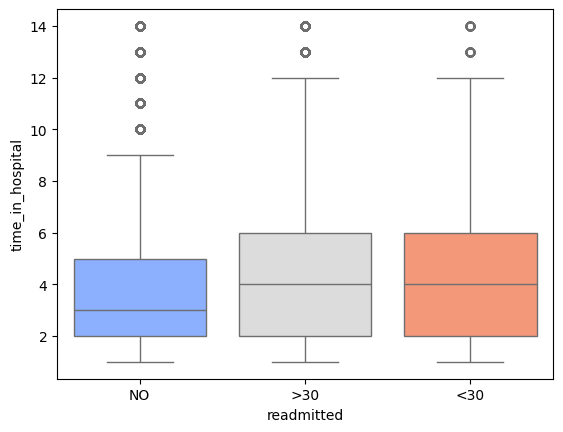

In [101]:
sns.boxplot(x='readmitted',y='time_in_hospital',data=dataset, palette='coolwarm', saturation=1.00)

C:\Users\giovi\AppData\Local\Temp\ipykernel_21140\2701787457.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted',y='n_treatments',data=dataset, palette='coolwarm', saturation=1.00)


<Axes: xlabel='readmitted', ylabel='n_treatments'>

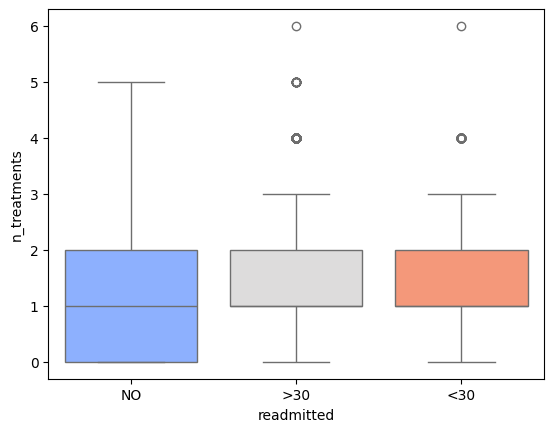

In [100]:
sns.boxplot(x='readmitted',y='n_treatments',data=dataset, palette='coolwarm', saturation=1.00)

C:\Users\giovi\AppData\Local\Temp\ipykernel_21140\2394464885.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted',y='num_lab_procedures',data=dataset, palette='coolwarm', saturation = 1)


<Axes: xlabel='readmitted', ylabel='num_lab_procedures'>

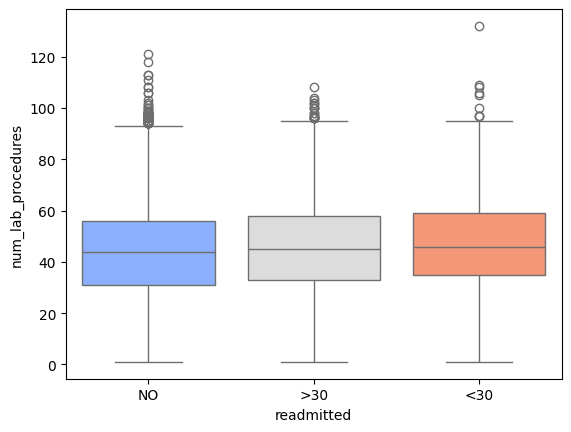

In [99]:
sns.boxplot(x='readmitted',y='num_lab_procedures',data=dataset, palette='coolwarm', saturation = 1)

The first feature, 'time_in_hospital', shows noticeably different distributions across target classes—especially in terms of their medians. The number of treatments seem to have different distributions across the dependent variable too.
The third feature, the number of laboratory procedures , by contrast, exhibits more homogeneous distributions across the classes.

### Correlation Analysis

We also analyze the potential correlations among the numerical variables and found no strong correlations, which leed us to retain all of them in the analysis.

The only notable observation concerns the number of medications, which shows some correlation with both the time spent in the hospital and the number of laboratory procedures. However, since the correlation coefficients are below 0.50, this relationship is not strong enough to justify the exclusion of any variable a priori.

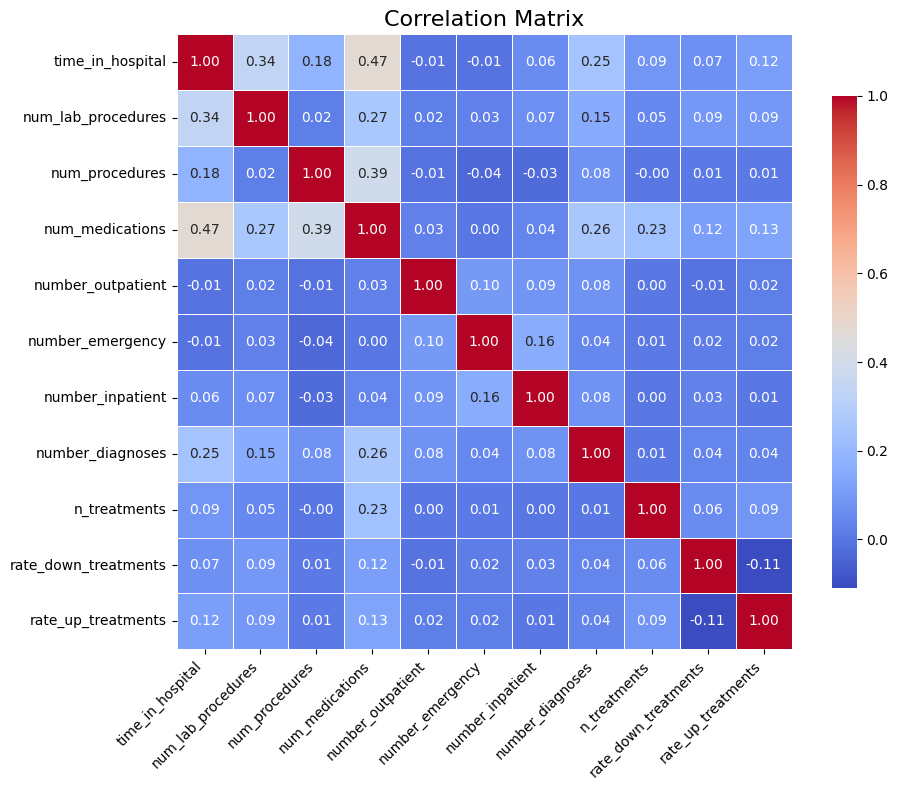

In [82]:
numeric_variables = dataset.select_dtypes(include='number')

corr_matrix = numeric_variables.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,        
            fmt=".2f",         
            cmap='coolwarm',   
            square=True,       
            cbar_kws={"shrink": 0.8},  
            linewidths=0.5,    
            linecolor='white')

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From a first look at the data we also identify a relevent problem: class imbalance for the target variable.

We will manage it below.

In [4]:
dataset.readmitted.value_counts()

readmitted
NO     33964
>30    18114
<30     5065
Name: count, dtype: int64

In [5]:
y = dataset['readmitted']

In [6]:
X = dataset.drop(columns = "readmitted", axis = 1)

# Data Preprocessing

### Training-Validation-Test split + Data Augmentation 
For each classification technique used, the approach id the same. The starting dataset is splitted between training and test set: this operation is performed as first one in order to obtain a test set that resembles the most to the real dataset.

Then, the training set is balanced using SMOTENC, i.e. the version of SMOTE for mixed datasets of both numerical and categorical variables.
So, model validation and hyperparameters tuning is done on the "balanced" training set (always performing 5 or 3 Fold Cross Validation) and the selected models are tested at the end to the test set.

Note that SMOTENC is applied only AFTER the train-test split to keep in the test set **only true data** and not generated ones.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15,stratify=y, random_state=42)

In [8]:
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

In [9]:
smote_nc = SMOTENC(categorical_features=categoric_columns, random_state=42)
X_SMOTENC, y_SMOTENC = smote_nc.fit_resample(X_train, y_train)

In [11]:
y_SMOTENC.value_counts()

readmitted
<30    28869
NO     28869
>30    28869
Name: count, dtype: int64

### Pipeline creation
For each model, we perform these preprocessing steps: 
- for numerical variables, we standardize them
- for categorical variables, we encode them with One Hot Encoding, because categories are not ordinal

We automize these steps using a pipeline composed of a ColumnTransformer preprocessor and the selected classifier.

In [12]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numeric_columns),
                                  ('cat',OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)])

# Model implementation
- Logistic Regression
- from Decision Trees to Random Forest
- AdaBoost 
- Ensemble method with majority voting

## Logistic Regression

The first model is a Multiclass (Softmax) Logistic Regression without regularization penalty.

In [13]:
pipeline_logistic = Pipeline([('preproc',preprocessor),
                     ('classifier', LogisticRegression(penalty=None,max_iter = 1000, multi_class='multinomial'))])

For completeness, it is important to explain why class imbalance is a problem that requires careful attention.

When a model is trained on an unbalanced dataset, it tends to learn a **"lazy" classification rule** — that is, it will classify most unseen instances as belonging to the majority class.

Moreover, it is important to emphasize that in such cases, accuracy is often not the most reliable metric. Relying solely on accuracy can be misleading, as it may give the false impression that the model is performing well, even when it fails to correctly identify the minority class.

**Accuracy** is also particularly inadequate when different types of misclassification carry **different costs** or consequences. For example, in our case, predicting that a patient will not be readmitted to the hospital when they actually will is a more severe error.

For this reason, the primary metric we use is the **weighted F1 score**, which better captures the balance between precision and recall across classes. Accuracy is reported only as a secondary metric.

In [14]:
pipeline_logistic.fit(X_train, y_train)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    penalty=None))])

In [15]:
y_pred_logistic = pipeline_logistic.predict(X_test)

### Unreliability of accuracy

In [ ]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_logistic

0.6046430237984134

In [17]:
cm_logistic_unbalanced = confusion_matrix(y_test, y_pred_logistic)

The model classifies most unseen instances as belonging to the majority class.

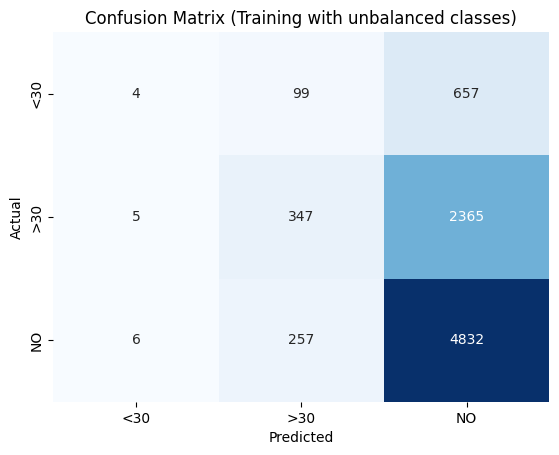

In [18]:
sns.heatmap(cm_logistic_unbalanced, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=pipeline_logistic.classes_, yticklabels=pipeline_logistic.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training with unbalanced classes)')
plt.show()

## Logistic Regression with augmented dataset (using SMOTENC)

Let's repeat the same steps again changing the metric and using the balanced dataset.


In [ ]:
f1_macro_validation = cross_val_score(pipeline_logistic, X_SMOTENC, y_SMOTENC, cv=5, scoring = 'f1_macro')


In [20]:
print(np.mean(f1_macro_validation))

0.49052912145892524


In [21]:
pipeline_logistic.fit(X_SMOTENC,y_SMOTENC)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    penalty=None))])

In [22]:
y_pred_logistic_SMOTENC = pipeline_logistic.predict(X_test)

In [23]:
cm_SMOTENC = confusion_matrix(y_test, y_pred_logistic_SMOTENC)

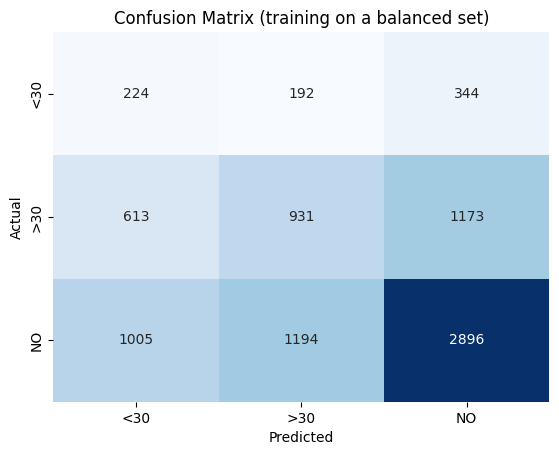

In [24]:
sns.heatmap(cm_SMOTENC, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=pipeline_logistic.classes_, yticklabels=pipeline_logistic.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (training on a balanced set)')
plt.show()

Note that for this part will be also used the F1 "macro" score, but only for graphical and validation purposes (because some tools in scikit-learn only have "f1_macro" as default). This is correct because the training set has been balanced before, and so using the weighted version of F1 score would lead to the same results.

In a multiclass problem, "F1_macro" is the mean of the F1 scores for each class, while the weighted takes into account the numerosity of each class.

In the testing phase, because we've decided to use a **stratified** test set  we will rely more on **weighted** f1 score, keeping also track for completeness of accuracy.

In [26]:
f1_logistic_weighted = f1_score(y_test, y_pred_logistic_SMOTENC, average='weighted')
f1_logistic_weighted

0.49458207349645644

In [ ]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic_SMOTENC)
accuracy_logistic

### Bias-Variance Analysis

In [27]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline_logistic,
    X=X_SMOTENC, y=y_SMOTENC,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='f1_macro'
)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

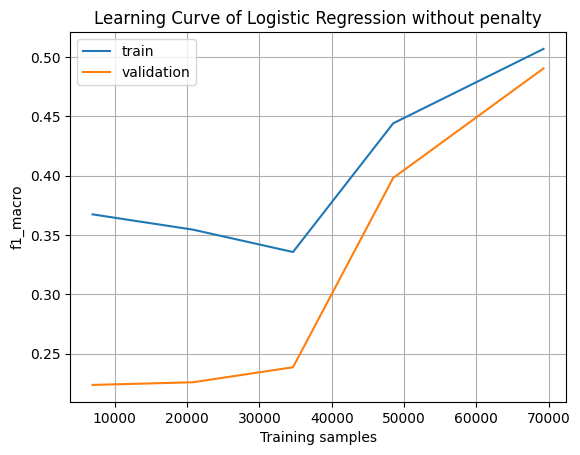

In [28]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("f1_macro")
plt.legend(); plt.grid()
plt.title("Learning Curve of Logistic Regression without penalty")
plt.show()


As the training size increases, the model improves its learning, evidenced by the validation score rising accordingly. Notably, from around 40,000 training observations onward, the model’s performance surpasses that of a **random choice model**.


Let's recall that Accuracy, Recall and Precision of a random classification model with $K=3$ classes are equal to $\frac{1}{K}$.

So, the f1_macro for a random classifier, which is the aritmetic mean of the $K$ f1 scores $F1_i$ related to each class with respect to the others, will be $$ F1_{i} = \frac{2 * Recall_i * Precision_i}{Recall_i + Precision_i} = \frac{2*\frac{1}{3}*\frac{1}{3}}{\frac{1}{3}+\frac{1}{3}} = \frac{1}{3}$$

Then, the mean of each score will be equal to $\frac{1}{3}$.

Looking at the validation and training performances with the maximum size of the training set used, we have performances on the training set which are only slightly higher than the ones on the validation set. 

This means that our model suffer from bias, and this could derived from multiple causes: 
- the chosen model could be too simple
- we could need more informative data in our input space


However, as we said, performances of the model are not too critical as they are consistently over the random choice performances.

So it can be meaningful a preliminary feature analysis of the model.

In particular, Logistic Recression offers an "integrated" feature selection approach, as it can be trained adding a penalization term in the loss function in order to limitate the norm of the parameters vector of the model.

One can perform both Ridge (L2) or Lasso (L1) regularization, but coherently to what we said before, in order to keep as much as possible information from the data, we will use Ridge regression.

In [29]:
pipeline_logistic.set_params(classifier__penalty = 'l2')

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [30]:
C_range = [10**exp for exp in [-5,-4,-3,-2,-1,0,1,2,3]]

In [31]:
train_scores, val_scores = validation_curve(
    pipeline_logistic, X_SMOTENC, y_SMOTENC,
    param_name="classifier__C", param_range=C_range,
    cv=5, scoring="f1_macro"
)


C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

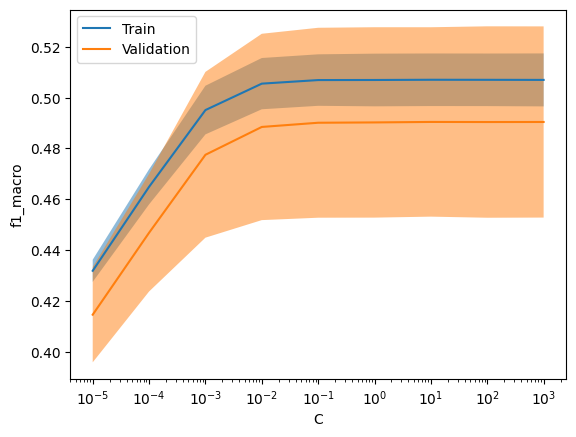

In [32]:
display = ValidationCurveDisplay(
    param_name="C", param_range=np.array(C_range),
    train_scores=train_scores, test_scores=val_scores, score_name="f1_macro"
)
display.plot()
plt.legend(['Train','Validation'])
plt.show()

A value of $C = 10^{-2}$ appears to offer a good **balance** for regularization, effectively penalizing complexity without sacrificing too much predictive information.

In [33]:
pipeline_logistic.set_params(classifier__C = 1e-2)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000,
                                    multi_class='multinomial'))])

In [34]:
pipeline_logistic.fit(X_SMOTENC,y_SMOTENC)

C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000,
                                    multi_class='multinomial'))])

In [ ]:
ohe = pipeline_logistic.named_steps['preproc'].named_transformers_['cat']
num_feats = numeric_columns
cat_feats = ohe.get_feature_names_out(categoric_columns)
feature_names = np.concatenate([num_feats, cat_feats])

In [36]:
logistic_reg = pipeline_logistic.named_steps['classifier']

In [37]:
coefs_logreg = np.abs(logistic_reg.coef_)

### Feature Importance Analysis and Explainability on Ridge Logistic Regression 

We employed two different metrics to analyze feature importance for this model:

- A **global metric**, calculated as the mean of the absolute values of each coefficient across all predicted classes, which aims to capture the overall impact of each feature.

- A detailed plot showing the **coefficients for each predicted class** individually, providing a deeper understanding of each feature’s specific role in the prediction process.



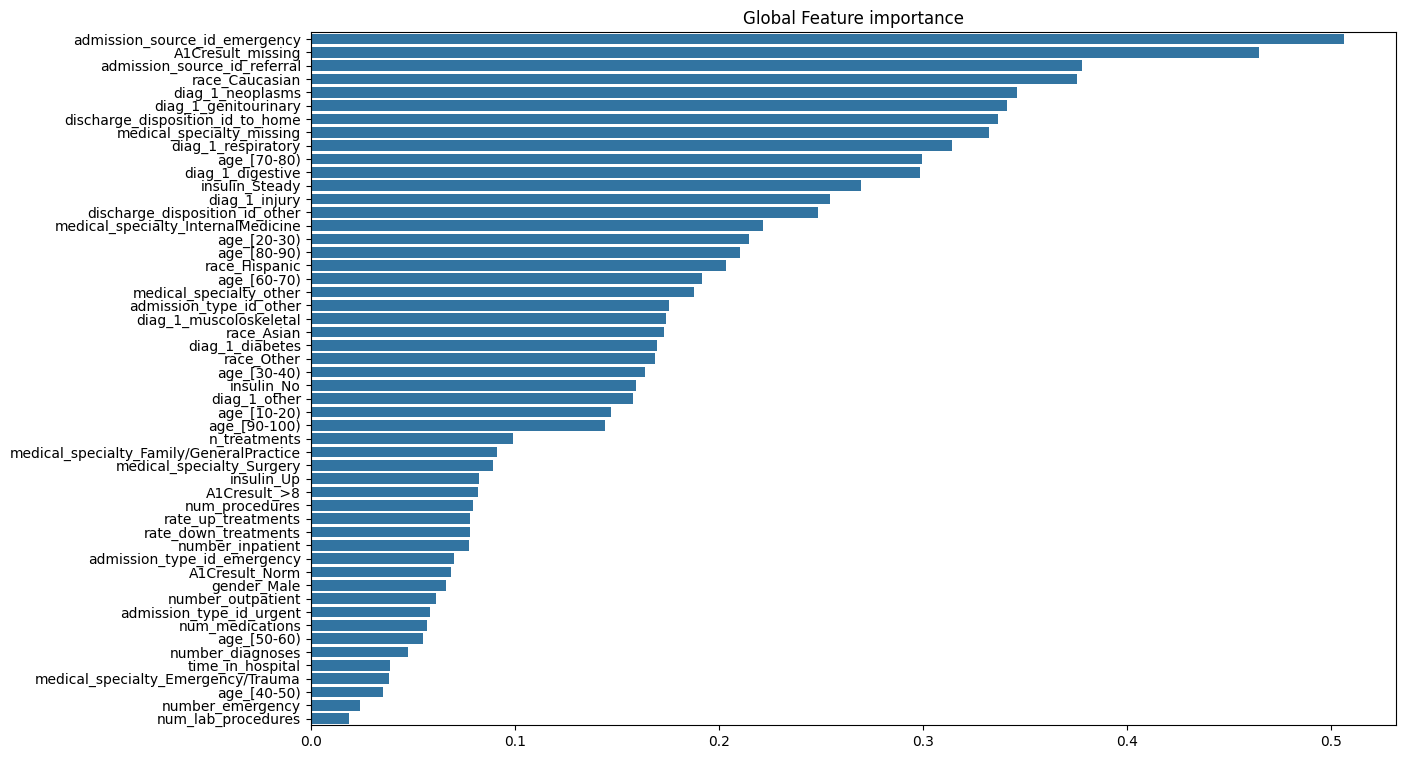

In [38]:
importance = np.mean(coefs_logreg, axis=0)
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(14,9))
sns.barplot(x=importance[indices], y=feature_names[indices])
plt.title("Global Feature importance")
plt.show()

From the global feature importance analysis, looking at the plot, it seems that features from n\_treatments to num\_lab\_procedures have not a great impact in terms of classifying one of the 3 classes. 

It is worth mentioning that this group of features includes almost every numerical variables, meaning that the categorical ones look more influent in this particular model. 

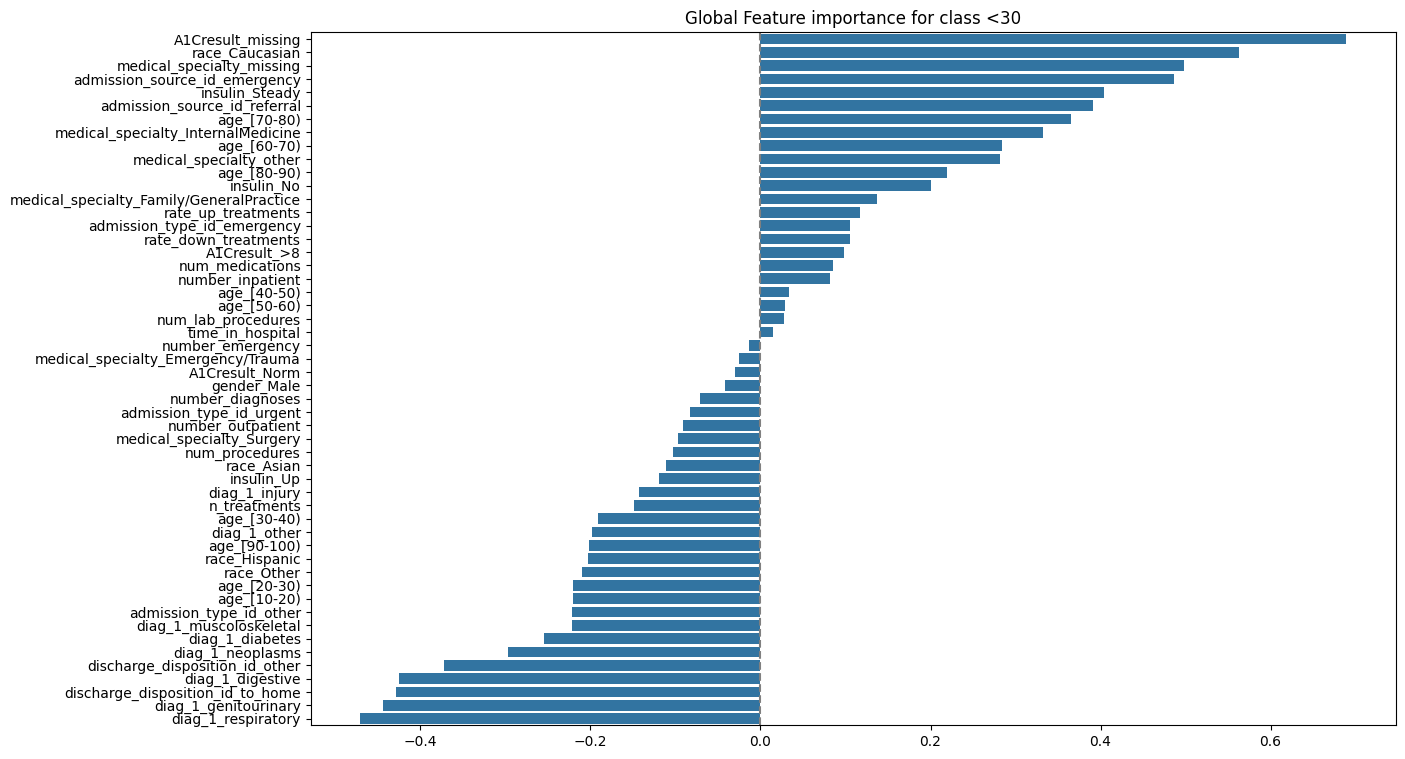

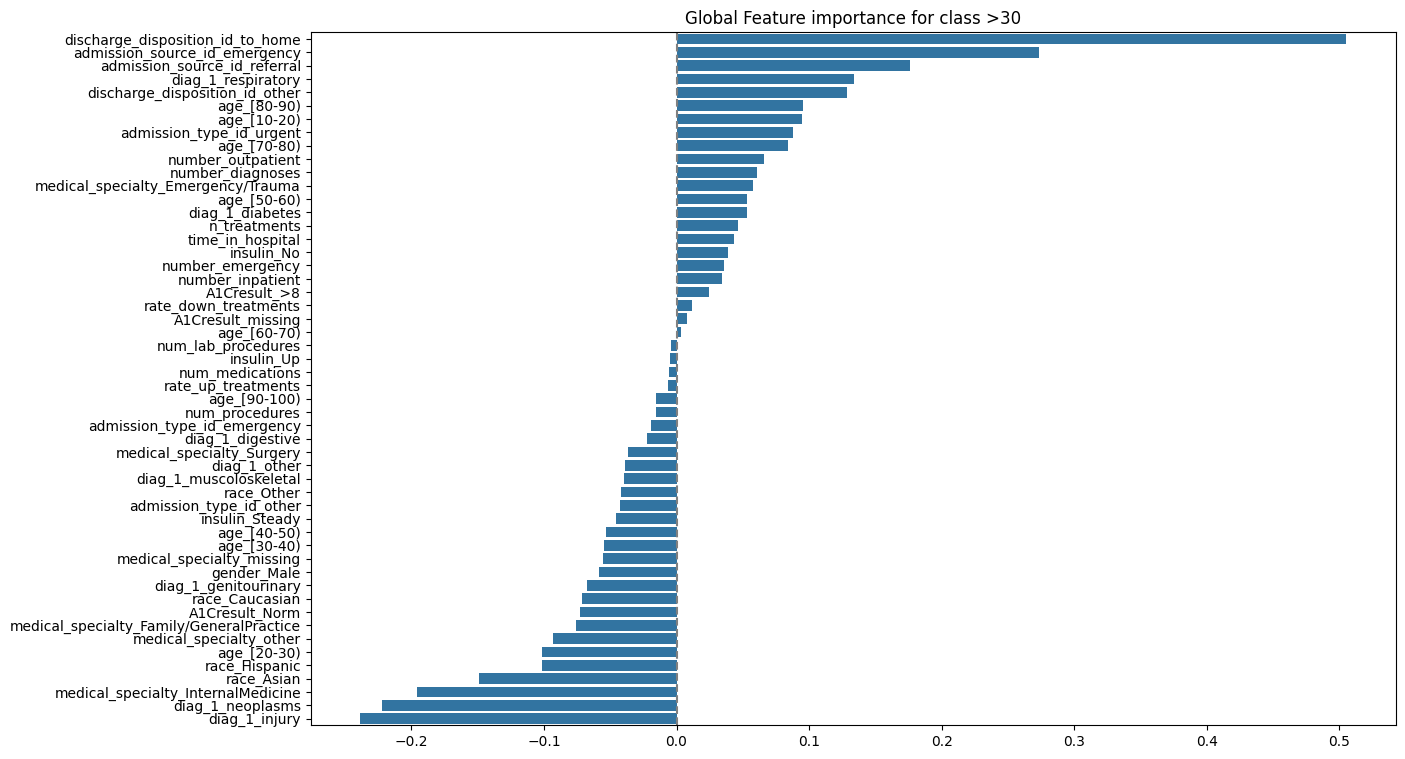

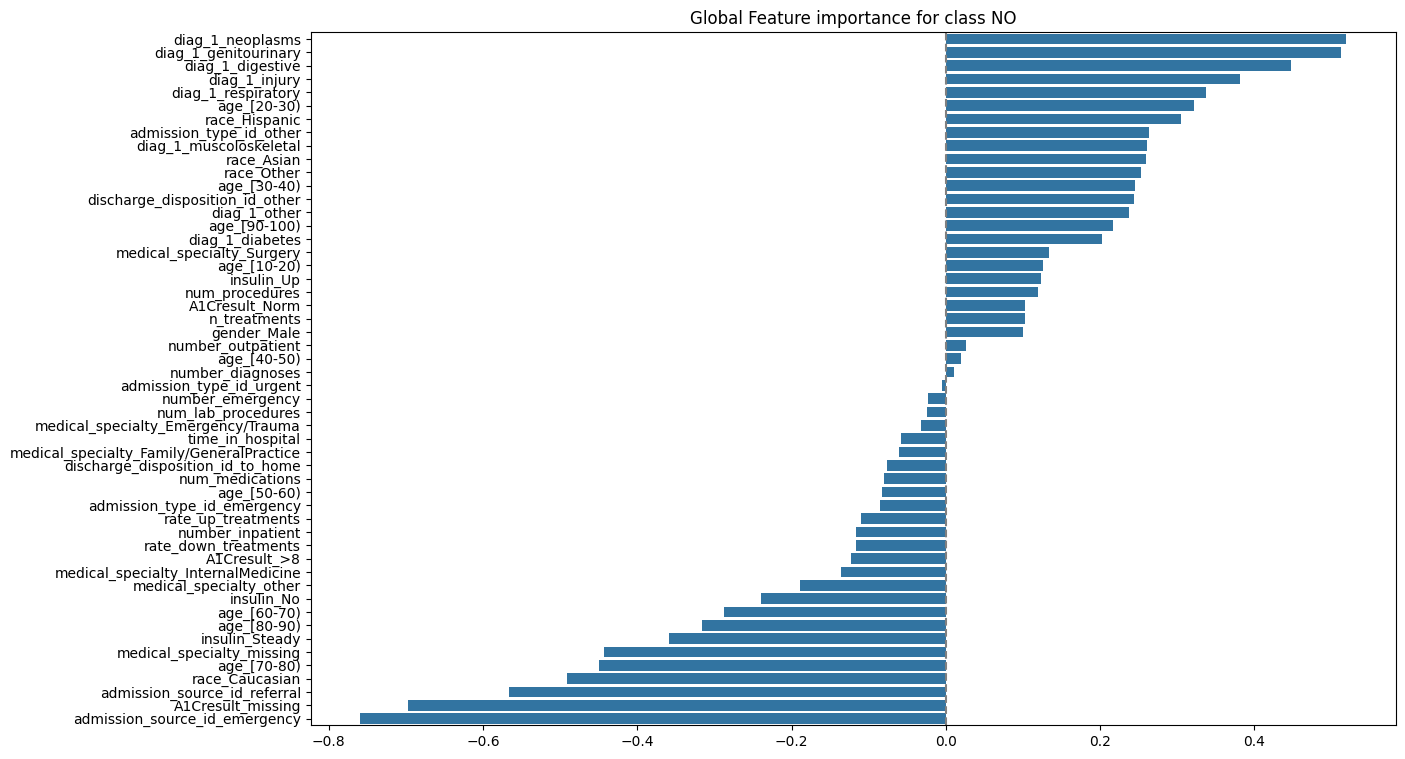

In [ ]:
for i in range(0,3):
    importance = logistic_reg.coef_[i]
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(14,9))
    sns.barplot(x=importance[indices], y=feature_names[indices])
    plt.title(f" Feature importance for class {logistic_reg.classes_[i]}")
    plt.axvline(0, color='gray', linestyle='--')
    plt.show()

Let's comment the three plots of the parameters associated to each class:
- for class '$< 30$'
    $A1cResult$ appears to be an influential feature, particularly when the glycated hemoglobin test was not performed during the visit. This may be due to the fact that in certain cases of hospitalization for critical conditions, the test was not conducted because it was not considered a priority. These critical conditions might be associated with health issues that are likely to reoccur in the short term.
    In fact, also the emergency admission type looks influent as well
- for class '$> 30$'
    the fact that the patient was discharged to home appears to be the most predictive feature. This opens up different possible interpretations—one of them being that in some cases, health problems might have been underestimated, leading to a relapse.
- For the parameters of the "NO" class, 
    several important insights emerge. The most influential factors seem to be certain principal diagnoses, which vary significantly in terms of severity. Among the most predictive variables are diagnoses related to the respiratory and digestive systems, as well as neoplasms.
    For less severe conditions, predicting no hospital readmission is relatively straightforward. In contrast, the presence of neoplasms suggests a different scenario. One possible explanation is that patients with such diagnoses may have initiated a supervised care pathway—including regular check-ups and a tailored treatment plan—which reduces the likelihood of urgent hospital readmission.



### Next Steps: Enhancing Performance and Interpretability
-Feature Space Enrichment (focus on model performance)

-Feature Selection via $L^1$ Regularization (focus on model interpretability)


### Polynomial Mapping of numerical features


At first, we tried to sacrifice some of the model interpretability to obtain some gains in term of prediction power. An attempt was done by introducing in the feature space a polynomial mapping of degree 2 of the continuous variables. 

However, as the learning curve below shows, improvements in term of performances were not enough to justify the choice of a model with such poor interpretability, so we decided to abandon this path.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

preprocessor2 = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown = 'ignore',drop='first'), categoric_columns)
])

pipeline2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', LogisticRegression(max_iter=1000, penalty=None))
])


In [ ]:
train_sizes2, train_scores2, val_scores2 = learning_curve(
    estimator=pipeline2,
    X=X_SMOTENC, y=y_SMOTENC,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='f1_macro'
)

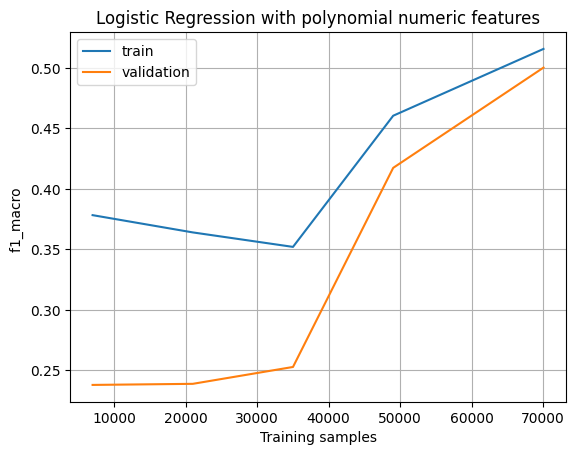

In [ ]:
plt.plot(train_sizes2, train_scores2.mean(axis=1), label='train')
plt.plot(train_sizes2, val_scores2.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("f1_macro ")
plt.title("Logistic Regression with polynomial numeric features")
plt.legend(); plt.grid()
plt.show()

In [ ]:
pipeline2.fit(X_SMOTENC,y_SMOTENC)

In [ ]:
y_pred_poly_logistic = pipeline2.predict(X_test)

In [ ]:
f1_poly_logistic = f1_score(y_test,y_pred_poly_logistic, average='weighted')
f1_poly_logistic

In [ ]:
accuracy_poly_logistic = accuracy_score(y_test,y_pred_poly_logistic)
accuracy_poly_logistic

### Lasso Logistic Regression for model explainability

We try to follow the opposite approach, that is to simplify as much as possible the model without losing too much in terms of predictive performances. 

In [ ]:
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    C=1.0)
)])

In [ ]:
param_grid = {
    'classifier__C': C_range
}

# Grid search con cross-validation
grid_search = GridSearchCV(
    pipeline_lasso,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1, verbose=3
)

grid_search.fit(X_SMOTENC, y_SMOTENC)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\giovi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['time_in_hospital',
                                                                          'num_lab_procedures',
                                                                          'num_procedures',
                                                                          'num_medications',
                                                                          'number_outpatient',
                                                                          'number_emergency',
                                                                          'number_inpatient',
                                                                          'number_diagnoses',
                                                                          'n_treatments',
                                                                          'rate_down_treatments',
                                                                          'rate_up_treatments']),
                                                                        ('cat',
                                                                         OneHotEncoder...
                                                                          'admission_type_id',
                                                                          'discharge_disposition_id',
                                                                          'admission_source_id',
                                                                          'medical_specialty',
                                                                          'diag_1',
                                                                          'A1Cresult',
                                                                          'insulin'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial',
                                                           penalty='l1',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                           10, 100, 1000]},
             return_train_score=True, scoring='f1_macro', verbose=3)

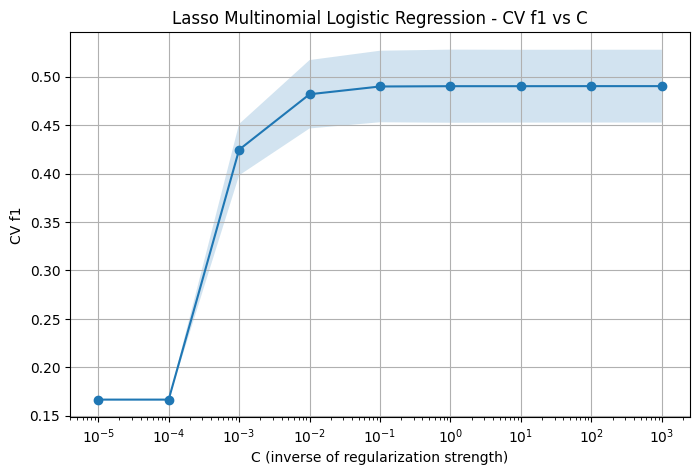

In [ ]:
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

plt.figure(figsize=(8, 5))
plt.semilogx(C_range, mean_scores, marker='o')
plt.fill_between(C_range, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)
plt.xlabel("C (inverse of regularization strength)")
plt.ylabel("CV f1")
plt.title("Lasso Multinomial Logistic Regression - CV f1 vs C")
plt.grid(True)
plt.show()

### Conservative Feature Selection with Lasso
The main goal of this approach is to simplify the model in order to retrieve more understandable results. At the same time we don't want to lose too much in terms of predictive power, so the selection of the regularization coefficient is done by taking the lowest C (i.e. the highest regularization strength) that still guarantees performances better than a random choice.

In [62]:
pipeline_lasso.set_params(classifier__C = 1e-3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000,
                                    multi_class='multinomial', penalty='l1',
                                    solver='saga'))])

In [ ]:
pipeline_lasso.fit(X_SMOTENC, y_SMOTENC)

In [66]:
lasso_model = pipeline_lasso.named_steps['classifier']
coefs_lasso = np.abs(lasso_model.coef_)

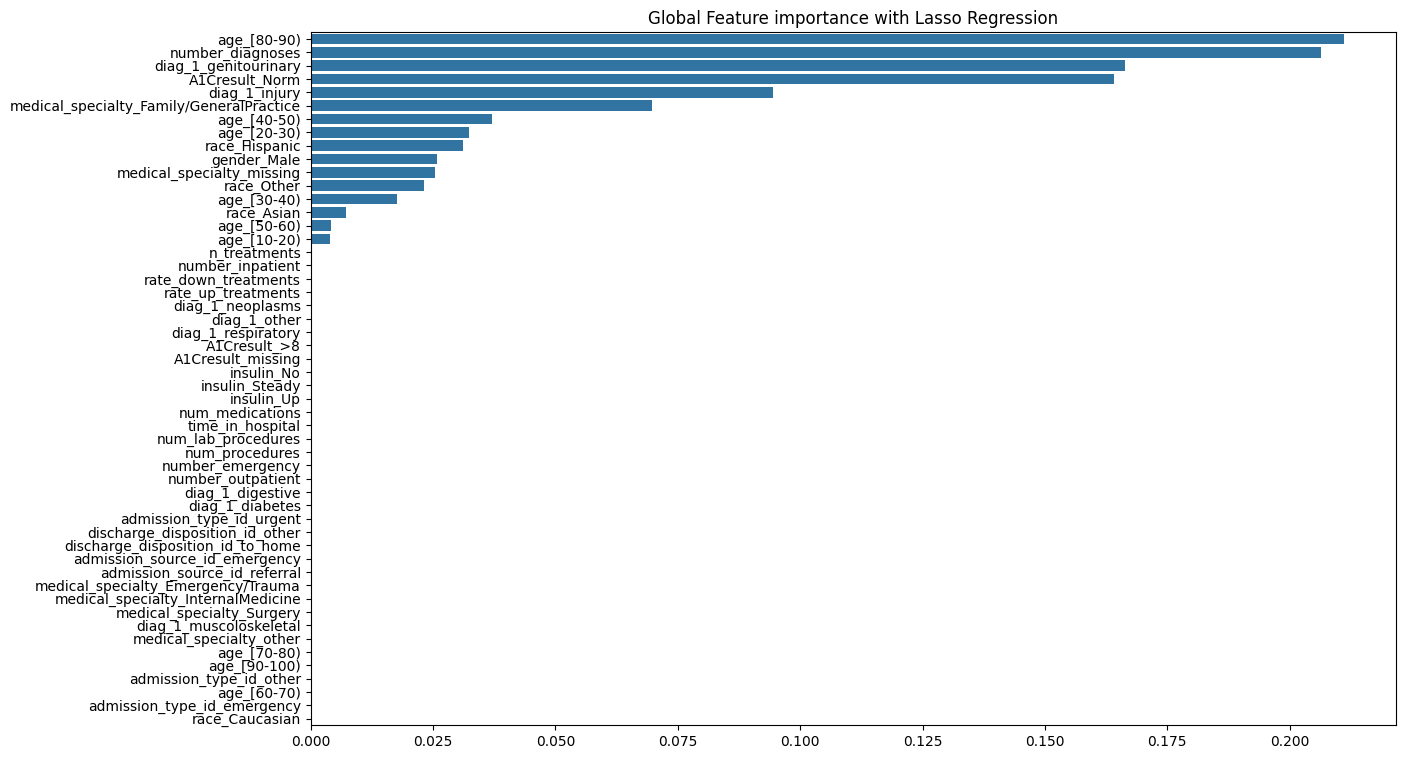

In [67]:
importance_lasso = np.mean(coefs_lasso, axis=0)
indices = np.argsort(importance_lasso)[::-1]

plt.figure(figsize=(14,9))
sns.barplot(x=importance_lasso[indices], y=feature_names[indices])
plt.title("Global Feature importance with Lasso Regression")
plt.show()

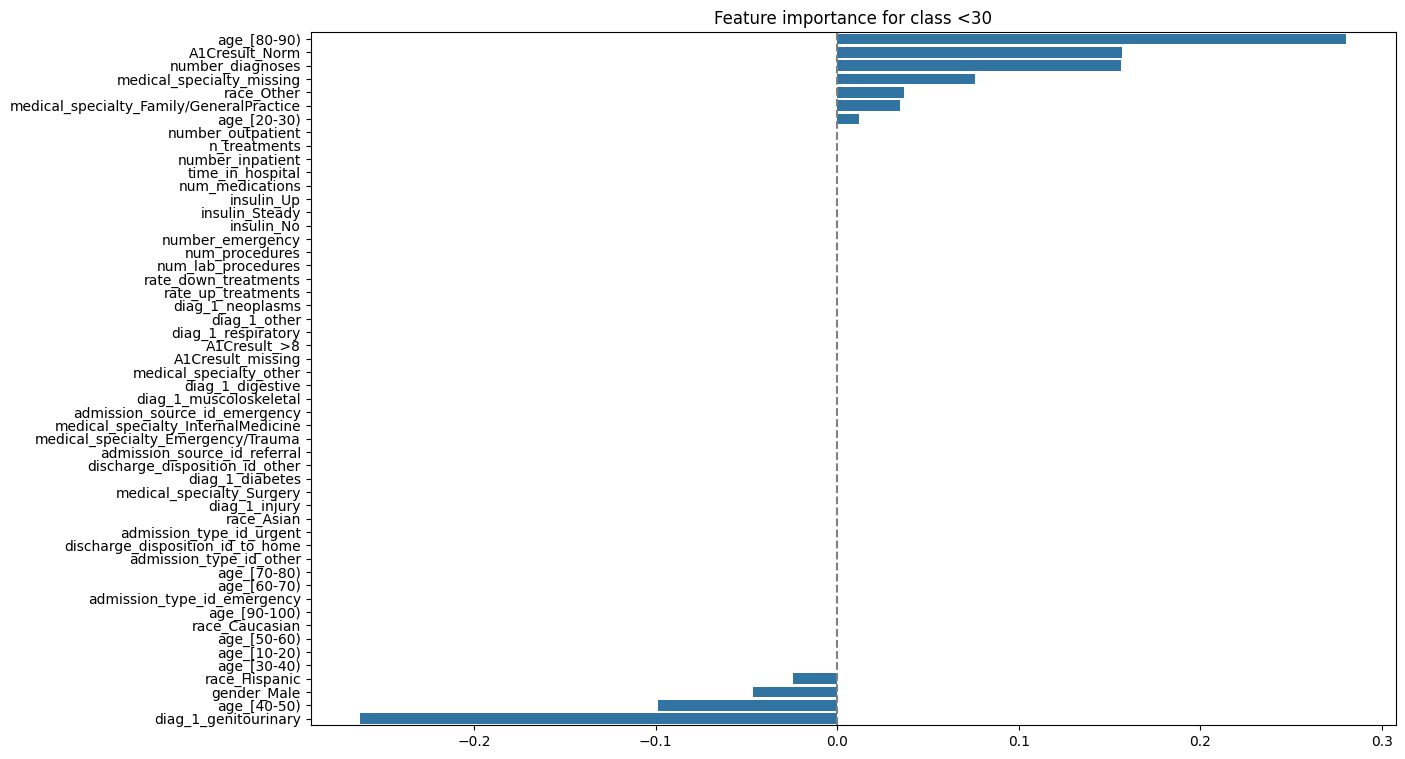

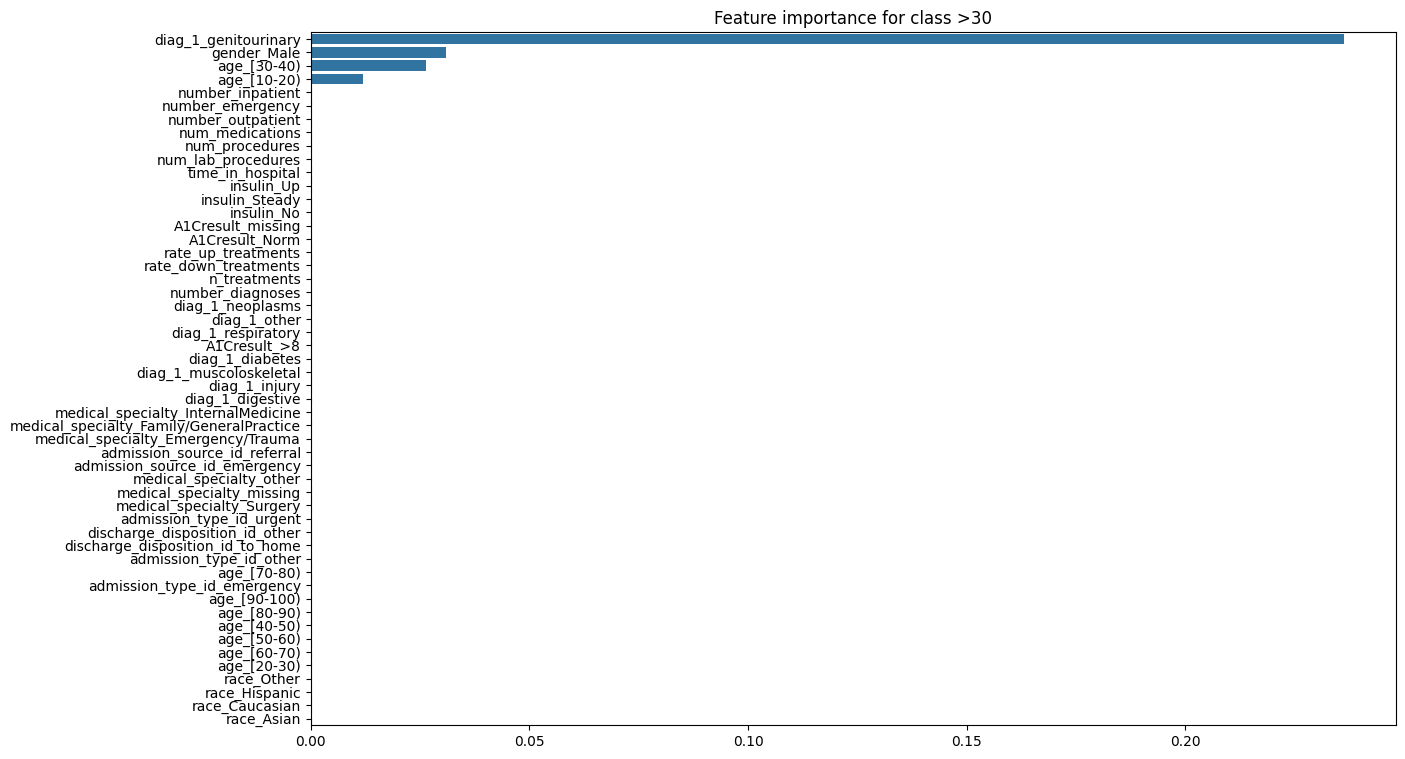

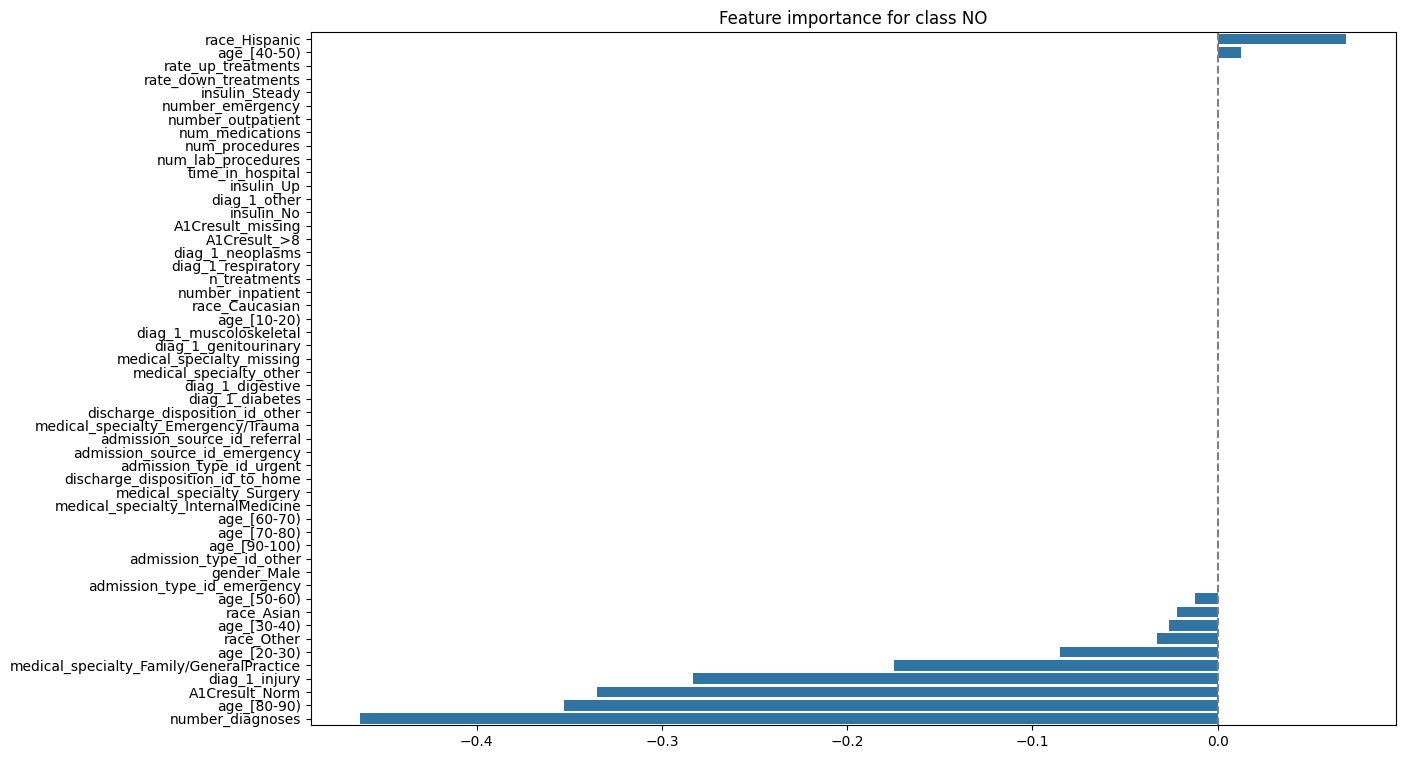

In [69]:
for i in range(0,3):
    importance_lasso_i = lasso_model.coef_[i]
    indices = np.argsort(importance_lasso_i)[::-1]

    plt.figure(figsize=(14,9))
    sns.barplot(x=importance_lasso_i[indices], y=feature_names[indices])
    plt.title(f"Feature importance for class {lasso_model.classes_[i]}")
    plt.axvline(0, color='gray', linestyle='--')
    plt.show()

To summarize the results, after the integrated feature selection offered by Lasso Regression, the most influent coefficients slightly differ from the most significant in Ridge regression. 

This is not totally unusual, as feature selection in Lasso Regression usually helps reduce the effect of some hidden patters of collinearity between variables. Some variables in fact could be significant only with other variables. 

Here, it seems that the age of the patient becomes more significative in predictive terms while using a small amount of features for the classification task.

However, there are also some similarities with the results discovered in Ridge Regression: for example, the principal diagnosis of problems to the  genitourinary system seems very predictive for a new hospitalization which is far in time.



In [64]:
prediction_lasso = pipeline_lasso.predict(X_test)

In [65]:
f1_score(y_test, prediction_lasso, average='weighted')

0.47761834273586207

In [ ]:
accuracy_score(y_test, prediction_lasso)

### Decision Tree 

In [10]:
pipeline_tree = Pipeline([('preproc', preprocessor),
                          ('classifier', DecisionTreeClassifier(max_depth=1, random_state=42))])

In [11]:
scores_tree = cross_val_score(pipeline_tree, X_resampled, y_resampled, cv=5)
np.mean(scores_tree)

np.float64(0.4035826822390664)

In [22]:
train_sizes_stump, train_scores_stump, val_scores_stump = learning_curve(
    estimator=pipeline_tree,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='accuracy'
)



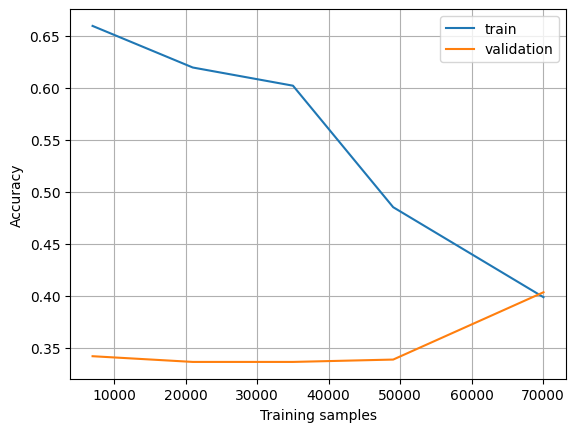

In [23]:
plt.plot(train_sizes_stump, train_scores_stump.mean(axis=1), label='train')
plt.plot(train_sizes_stump, val_scores_stump.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("Accuracy")
plt.legend(); plt.grid()
plt.show()


In [24]:
max_depth_range = range(1,30)
train_scores_trees, val_scores_trees = validation_curve(
    pipeline_tree, X_resampled, y_resampled,
    param_name="classifier__max_depth", param_range=max_depth_range,
    cv=5, scoring="accuracy"
)


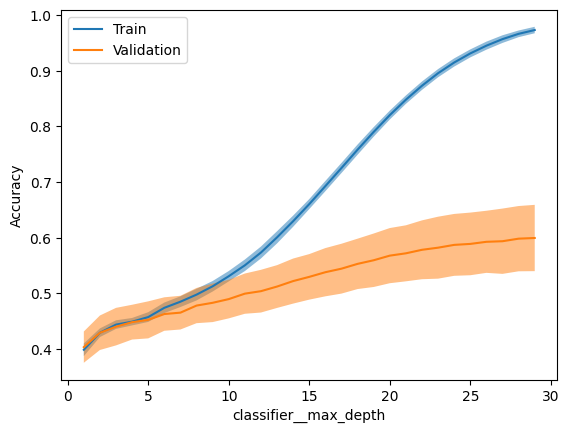

In [31]:
#from sklearn.model_selection import ValidationCurveDisplay
#ValidationCurveDisplay(pipeline, param_name, param_range, train_scores, val_scores, score_name=None)
display_trees = ValidationCurveDisplay(
    param_name="classifier__max_depth", param_range=max_depth_range,
    train_scores=train_scores_trees, test_scores=val_scores_trees, score_name="Accuracy"
)
display_trees.plot()
plt.legend(['Train','Validation'])
plt.show()

In [33]:
pipeline_tree_prova = Pipeline([('preprocessing', preprocessor),
                                ('classifier', DecisionTreeClassifier(max_depth = 29, random_state = 42))])

In [34]:
pipeline_tree_prova.fit(X_resampled,y_resampled)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=29, random_state=42))])

In [35]:
y_predicted = pipeline_tree_prova.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score as accuracy

In [37]:
accuracy(y_predicted, y_test)

0.44752085264133457

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
pipeline_rf = Pipeline([('preproc', preprocessor),
                          ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

In [40]:
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    estimator=pipeline_rf,
    X=X_resampled, y=y_resampled,
    cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    scoring='f1_macro'
)



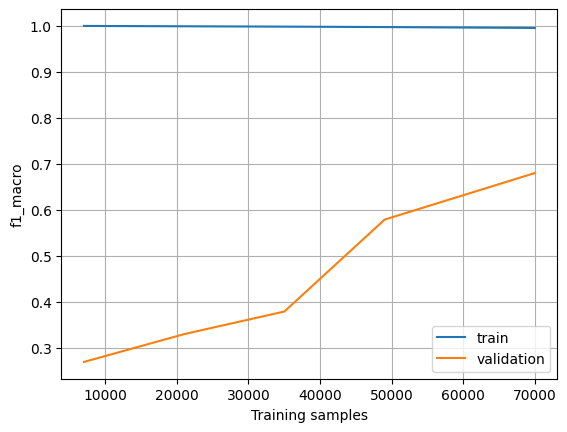

In [41]:
plt.plot(train_sizes_rf, train_scores_rf.mean(axis=1), label='train')
plt.plot(train_sizes_rf, val_scores_rf.mean(axis=1), label='validation')
plt.xlabel("Training samples"); plt.ylabel("f1_macro")
plt.legend(); plt.grid()
plt.show() 


In [105]:
n_estimators_range = [10,100,1000]
train_scores_rf, val_scores_rf = validation_curve(
    pipeline_rf, X_resampled, y_resampled,
    param_name="classifier__n_estimators", param_range=n_estimators_range,
    cv=5, scoring="accuracy"
)


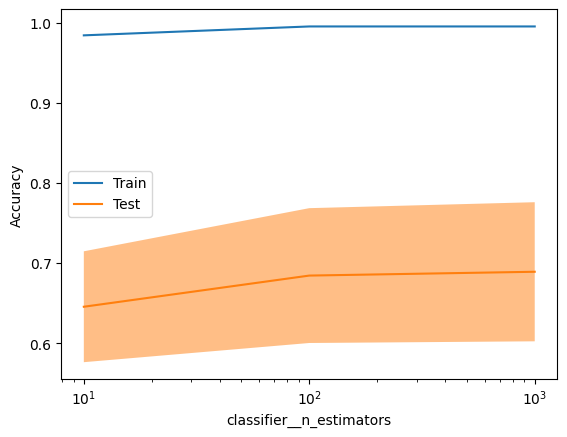

In [106]:
display_rf = ValidationCurveDisplay(
    param_name="classifier__n_estimators", param_range=np.array(n_estimators_range),
    train_scores=train_scores_rf, test_scores=val_scores_rf, score_name="Accuracy"
)
display_rf.plot()
plt.show()

## AdaBoost

In [43]:
from sklearn.ensemble import AdaBoostClassifier

In [59]:
base_clf = DecisionTreeClassifier(max_depth=3)

pipeline_boost = Pipeline([('preprocessor', preprocessor),
                          ('classifier', AdaBoostClassifier(estimator=base_clf, n_estimators=500))]) 



In [60]:
pipeline_boost.fit(X_SMOTENC,y_SMOTENC)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'n_treatments',
                                                   'rate_down_treatments',
                                                   'rate_up_treatments']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'medical_specialty',
                                                   'diag_1', 'A1Cresult',
                                                   'insulin'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                    n_estimators=500))])

In [61]:
y_predicted_boost = pipeline_boost.predict(X_test)

In [62]:
f1_score(y_predicted_boost,y_test, average='weighted')

0.5160738112736609

In [63]:
model_boost = pipeline_boost.named_steps['classifier']

In [64]:
# Ottieni il transformer OneHotEncoder dalla pipeline
ohe = pipeline_logistic.named_steps['preproc'].named_transformers_['cat']

# Ottieni i nomi delle feature numeriche (non cambiano con la trasformazione)
num_feats = numeric_columns

# Ottieni i nomi delle feature categoriche trasformate da OneHotEncoder
cat_feats = ohe.get_feature_names_out(categoric_columns)

# Combina le feature numeriche e quelle one-hot encode
feature_names = np.concatenate([num_feats, cat_feats])


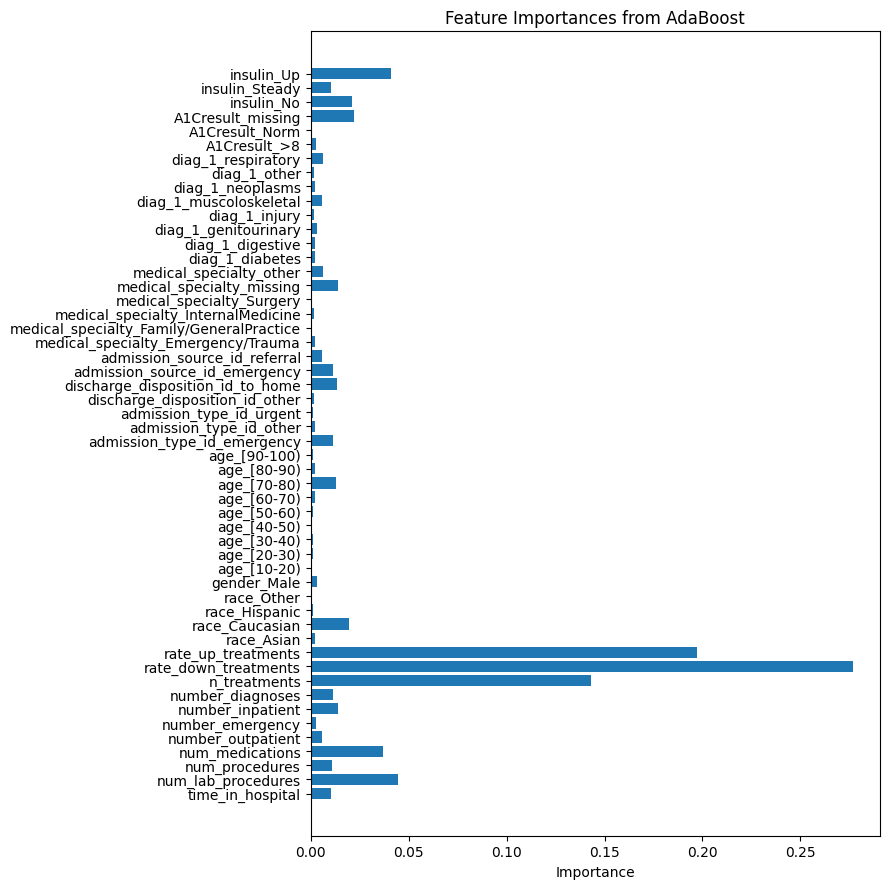

In [65]:
importances = model_boost.feature_importances_

# Visualizzazione
plt.figure(figsize=(9, 9))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importances from AdaBoost")
plt.tight_layout()
plt.show()



### Ensemble 

### Data Visualization

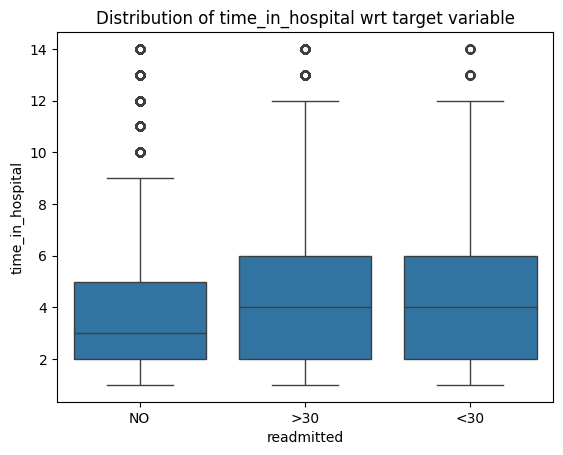

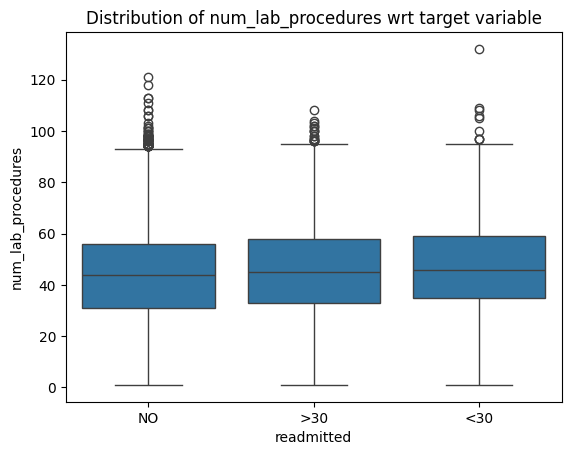

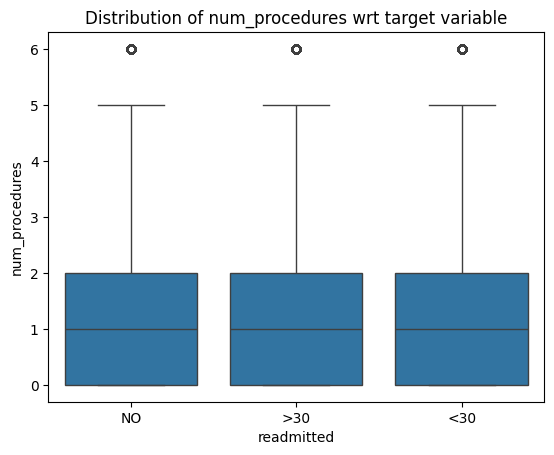

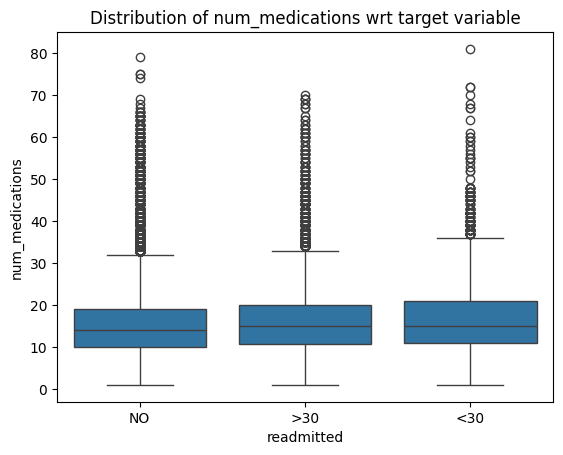

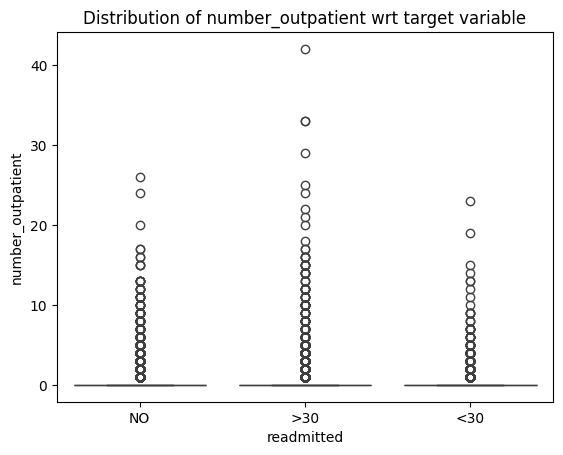

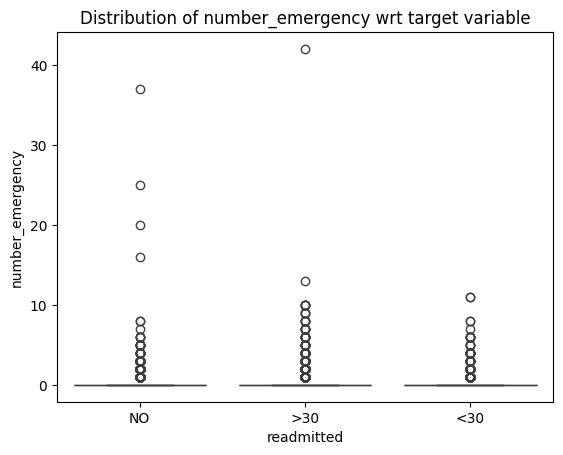

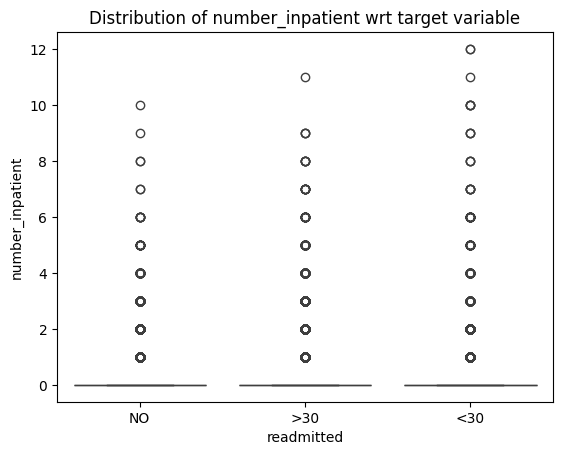

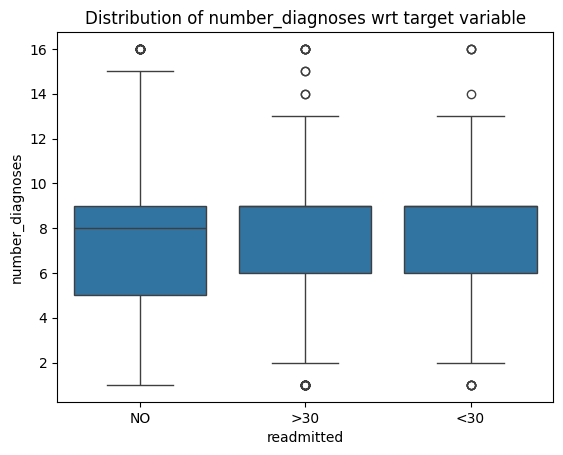

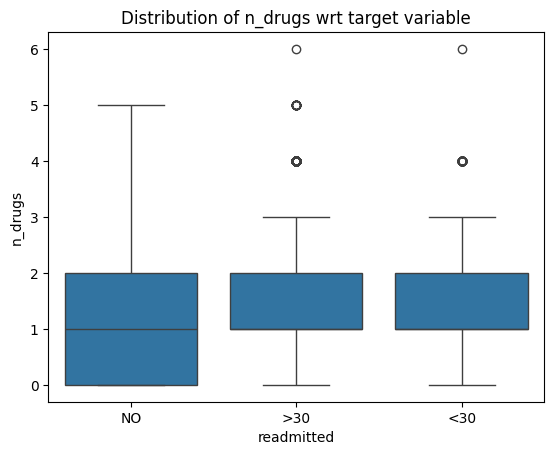

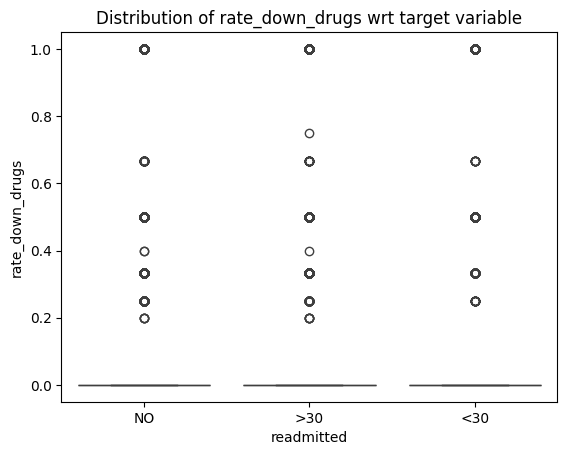

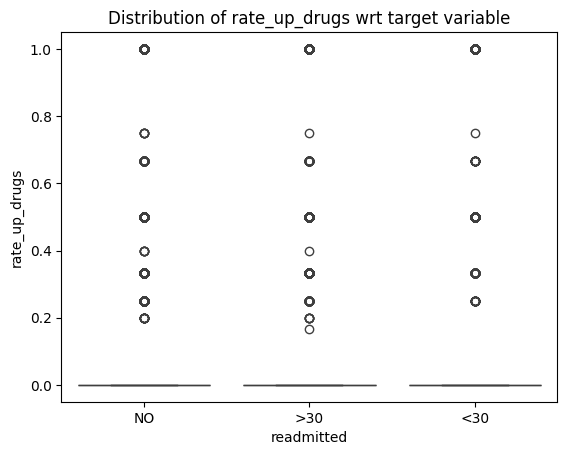

In [27]:
for col in numeric_columns:
    sns.boxplot(data=dataset, x='readmitted', y=col)
    plt.title(f'Distribution of {col} wrt target variable')
    plt.show()

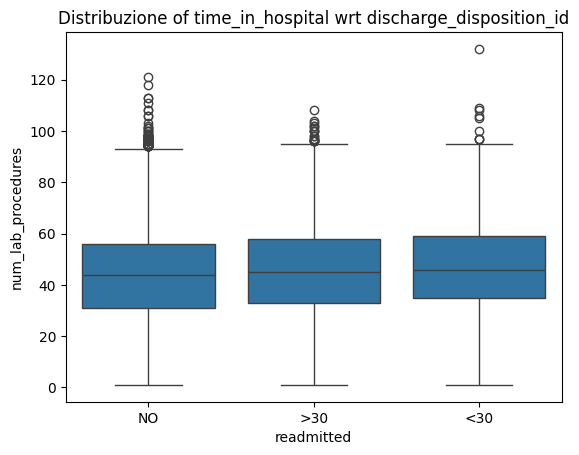

In [24]:
sns.boxplot(data=dataset, x='readmitted', y='num_lab_procedures')
plt.title('Distribuzione of time_in_hospital wrt discharge_disposition_id')
plt.show()

### 1st attempt to reduce the number of variables: using Logistic Regression with Lasso

In [44]:
Log_Reg_Lasso = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=1.0,
    multi_class='multinomial',
    max_iter=5000,  # spesso serve iterare di più
    random_state=42
)

In [42]:
pipe_lasso = Pipeline([('preproc',preprocessor),
                     ('classifier', Log_Reg_Lasso)])

In [43]:
pipe_lasso.fit(X_train, y_train)

InvalidParameterError: The 'multi_class' parameter of LogisticRegression must be a str among {'multinomial', 'ovr', 'auto'}. Got 'softmax' instead.